In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from eval_data import data_structured

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

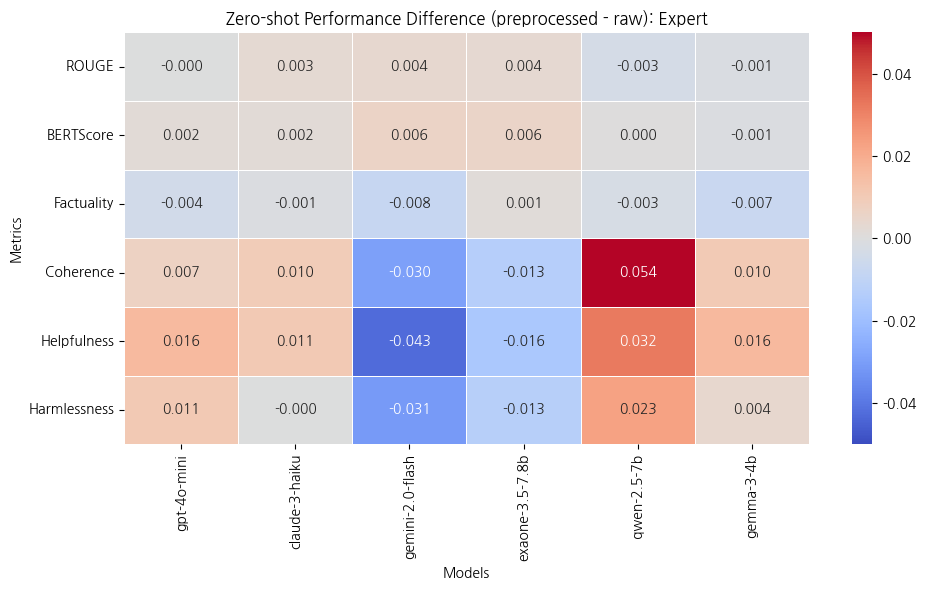

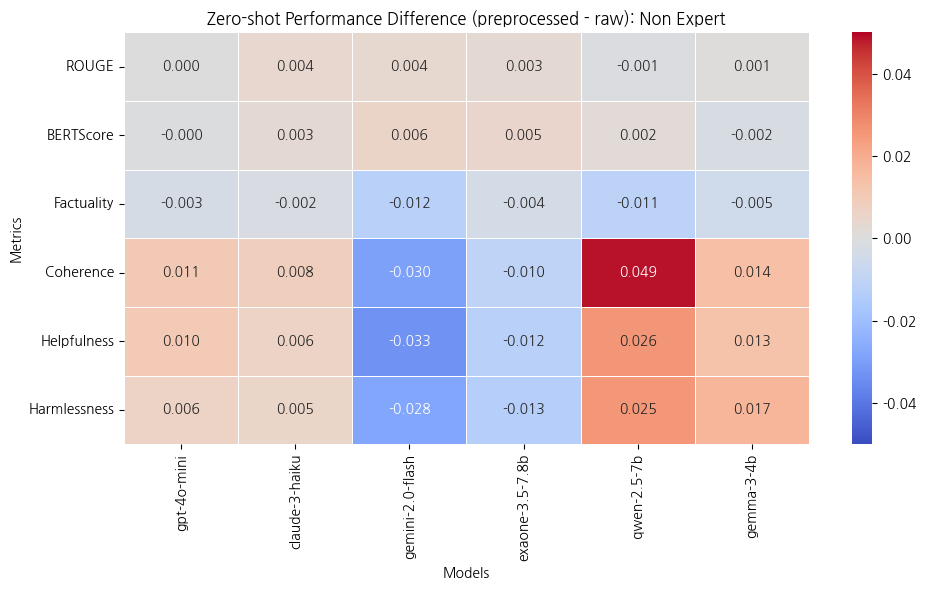

In [4]:
# dog, cat 가중평균
sample_counts = {
    'Expert': {
        'Dog': 2083,
        'Cat': 413,
    },
    'Non Expert': {
        'Dog': 4541,
        'Cat': 2963,
    }
}


# coh, help, harm: min-max 정규화 후 결과
models = ['gpt-4o-mini', 'claude-3-haiku', 'gemini-2.0-flash', 'exaone-3.5-7.8b', 'qwen-2.5-7b', 'gemma-3-4b']
metrics = ['ROUGE', 'BERTScore', 'Factuality', 'Coherence', 'Helpfulness', 'Harmlessness']
expert_types = ['Expert', 'Non Expert']

likert_metrics = ['Coherence', 'Helpfulness', 'Harmlessness']
def normalize_likert(value):
    return (value - 1) / (5 - 1)

diff_dfs = {}
for expert_type in expert_types:
    diff_data = pd.DataFrame(index=metrics, columns=models, dtype=float)
    
    for model in models:
        for metric in metrics:
            # Dog 데이터 처리
            dog_preprocessed_0shot = data_structured[expert_type][model]['Dog']['preprocessed'][0][metric]
            dog_raw_0shot = data_structured[expert_type][model]['Dog']['raw'][0][metric]
            
            if metric in likert_metrics:
                dog_preprocessed_0shot = normalize_likert(dog_preprocessed_0shot)
                dog_raw_0shot = normalize_likert(dog_raw_0shot)
            
            # Cat 데이터 처리
            cat_preprocessed_0shot = data_structured[expert_type][model]['Cat']['preprocessed'][0][metric]
            cat_raw_0shot = data_structured[expert_type][model]['Cat']['raw'][0][metric]
            
            if metric in likert_metrics:
                cat_preprocessed_0shot = normalize_likert(cat_preprocessed_0shot)
                cat_raw_0shot = normalize_likert(cat_raw_0shot)
            
            # 샘플 수
            dog_n = sample_counts[expert_type]['Dog']
            cat_n = sample_counts[expert_type]['Cat']

            # 가중 평균
            dog_diff = dog_preprocessed_0shot - dog_raw_0shot
            cat_diff = cat_preprocessed_0shot - cat_raw_0shot

            difference = (dog_n * dog_diff + cat_n * cat_diff) / (dog_n + cat_n)
            diff_data.loc[metric, model] = difference
    diff_dfs[expert_type] = diff_data

for expert_type, df in diff_dfs.items():
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, vmin=-0.05, vmax=0.05)
    plt.title(f'Zero-shot Performance Difference (preprocessed - raw): {expert_type}')
    plt.xlabel('Models')
    plt.ylabel('Metrics')
    plt.tight_layout()

paired t test

In [ ]:
from scipy import stats

t_statistic, p_value = stats.ttest_rel(df['score_after'], df['score_before'])

print("--- Paired t-test 결과 ---")
print(f"t-통계량: {t_statistic:.4f}")
print(f"p-값 (p-value): {p_value:.4f}")

# 결과 해석
alpha = 0.05
if p_value > alpha:
    print("\n결론: 전처리 효과는 통계적으로 유의미하지 않습니다 (p > 0.05).")
else:
    print("\n결론: 전처리 효과는 통계적으로 유의미합니다 (p <= 0.05).")
    

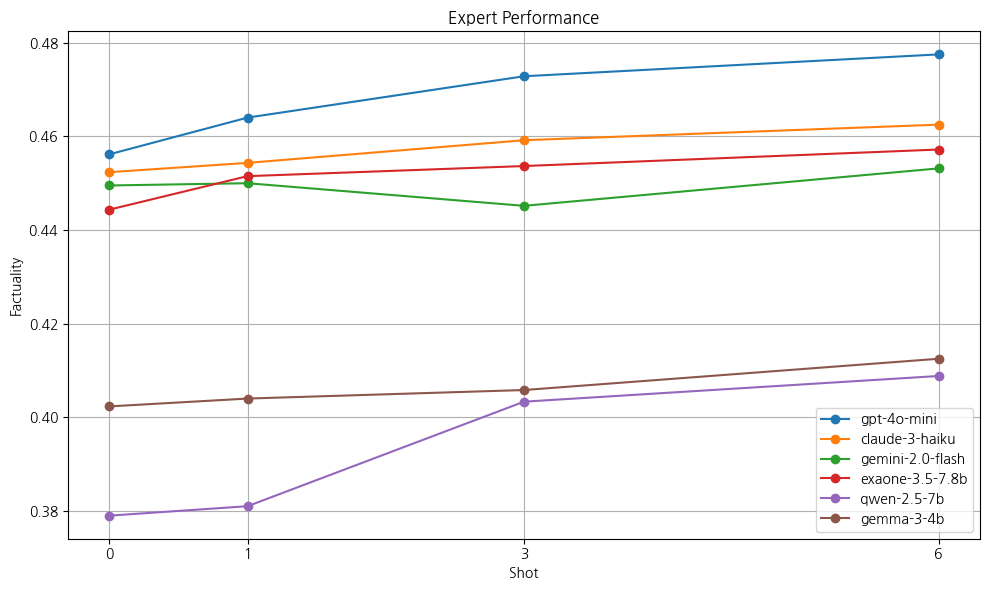

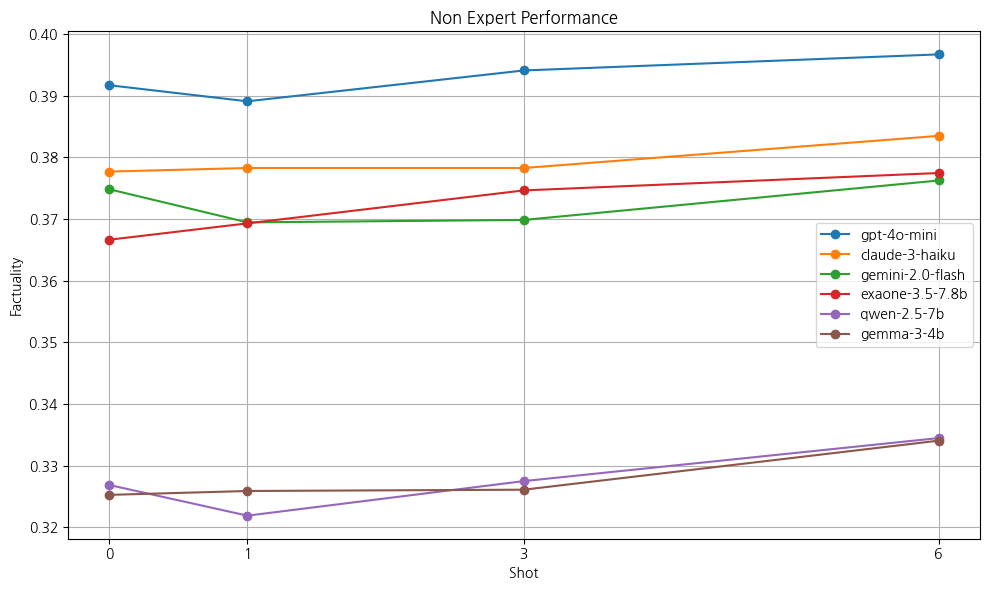

In [11]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# dog, cat 가중평균
sample_counts = {
    'Expert': {
        'Dog': 2083,
        'Cat': 413,
    },
    'Non Expert': {
        'Dog': 4541,
        'Cat': 2963,
    }
}

def plot_bert_score(data, group, metric, input_format='preprocessed'):
    plt.figure(figsize=(10, 6))
    models = list(data[group].keys())

    shot_types = [0, 1, 3, 6]
    for model in models:
        shot_scores_weighted = defaultdict(lambda: {'scores': [], 'weights': []})
        
        for animal_type in data[group][model].keys():  # e.g., 'Dog', 'Cat'
            subdata = data[group][model][animal_type].get(input_format)
            weight = sample_counts[group][animal_type]  # 해당 동물의 샘플 수
            
            for shot, metrics in subdata.items():
                if shot in shot_types:
                    shot_scores_weighted[shot]['scores'].append(metrics[metric])
                    shot_scores_weighted[shot]['weights'].append(weight)

        # 가중평균 계산
        avg_shots = sorted(shot_scores_weighted.keys())
        avg_scores = []
        
        for shot in avg_shots:
            scores = shot_scores_weighted[shot]['scores']
            weights = shot_scores_weighted[shot]['weights']
            
            # 가중평균: Σ(score * weight) / Σ(weight)
            weighted_avg = np.average(scores, weights=weights)
            avg_scores.append(weighted_avg)

        plt.plot(avg_shots, avg_scores, marker='o', label=model)

    plt.title(f"{group} Performance")
    plt.xlabel("Shot")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks([0, 1, 3, 6])
    plt.show()

metric = 'Factuality'
plot_bert_score(data_structured, group='Expert', metric=metric)
plot_bert_score(data_structured, group='Non Expert', metric=metric)

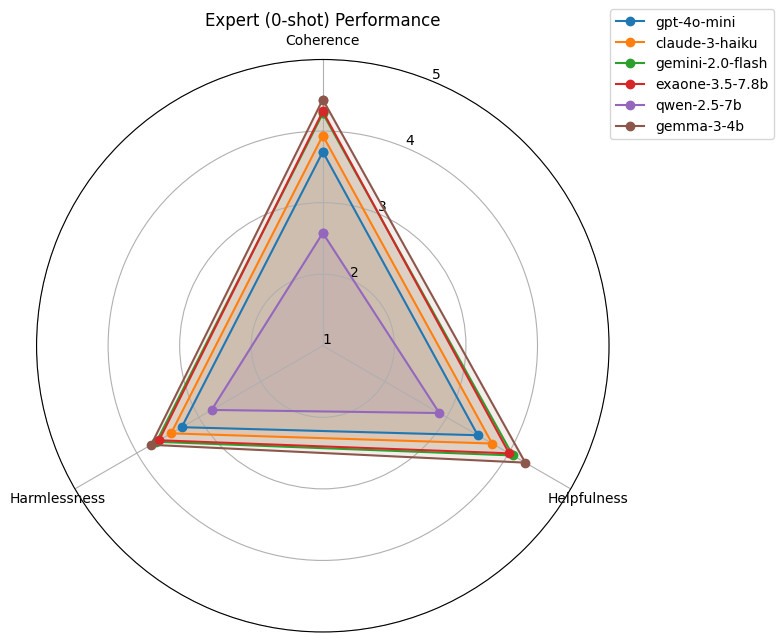

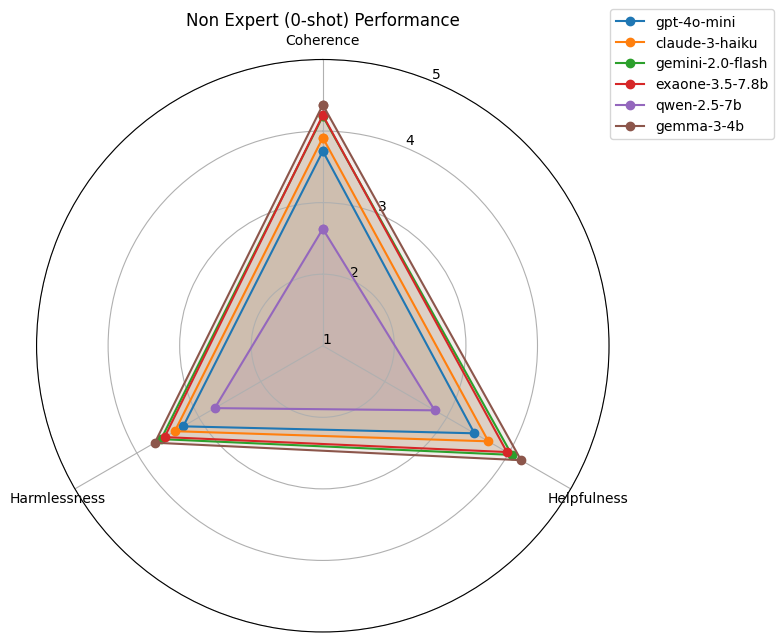

In [17]:
def plot_radar_scores(data, group, input_format='preprocessed', shot=0, metrics=['Coherence', 'Helpfulness', 'Harmlessness']):
    models = list(data[group].keys())
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # 첫번째로 닫아줌 (원형)

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    for model in models:
        metric_vals = []
        for metric in metrics:
            vals = []
            for topic in data[group][model].keys():
                topic_data = data[group][model][topic].get(input_format, {})
                if shot in topic_data and topic_data[shot].get(metric) is not None:
                    vals.append(topic_data[shot][metric])
            if vals:
                metric_vals.append(np.mean(vals))
            else:
                metric_vals.append(0)  # 결측 시 0 또는 np.nan
        metric_vals += metric_vals[:1]  # 첫번째로 닫기

        ax.plot(angles, metric_vals, marker='o', label=model)
        ax.fill(angles, metric_vals, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title(f"{group} ({shot}-shot) Performance")
    ax.set_ylim(1, 5)  # 1~5점 척도
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'])
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# 사용 예시
plot_radar_scores(data_structured, group='Expert')
plot_radar_scores(data_structured, group='Non Expert')


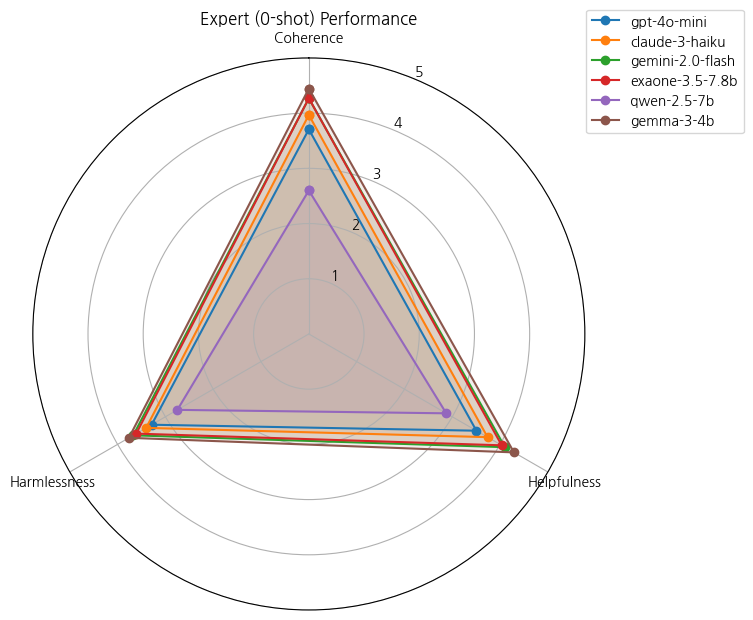

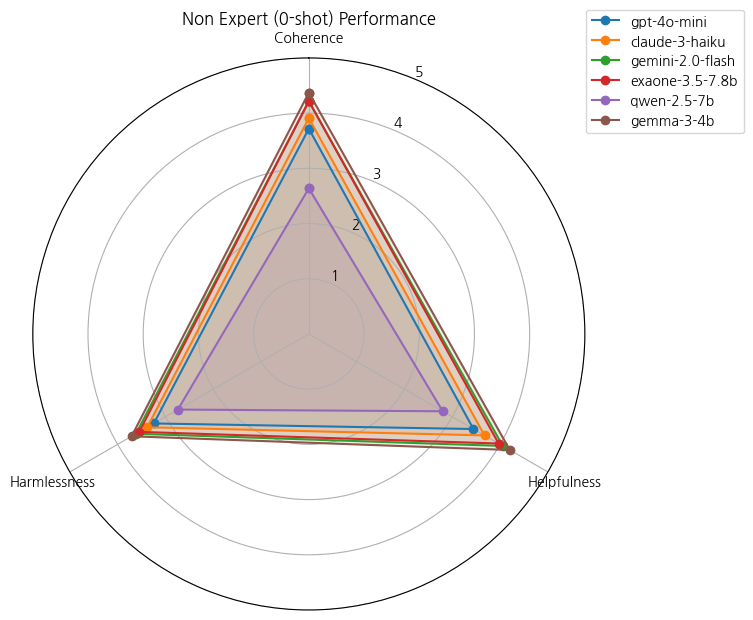

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def plot_radar_scores_weighted(data, sample_counts, group, input_format='preprocessed', shot=0, metrics=['Coherence', 'Helpfulness', 'Harmlessness']):
    models = list(data[group].keys())
    num_metrics = len(metrics)
    
    # Radar Chart의 각도 설정
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # 차트를 닫기 위해 첫 각도를 마지막에 추가

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    for model in models:
        metric_vals = []
        for metric in metrics:
            scores = []
            weights = []
            
            for animal_type in data[group][model].keys():
                weight = sample_counts.get(group, {}).get(animal_type)
                animal_data = data[group][model][animal_type].get(input_format, {})
                scores.append(animal_data[shot][metric])
                weights.append(weight)

            weighted_avg = np.average(scores, weights=weights)
            metric_vals.append(weighted_avg)
                
        metric_vals += metric_vals[:1]  # 차트를 닫기 위해 첫 값을 마지막에 추가

        ax.plot(angles, metric_vals, marker='o', label=model)
        ax.fill(angles, metric_vals, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title(f"{group} ({shot}-shot) Performance")
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    plt.tight_layout(pad=2.0)
    plt.show()

sample_counts = {
    'Expert': {
        'Dog': 2083,
        'Cat': 413,
    },
    'Non Expert': {
        'Dog': 4541,
        'Cat': 2963,
    }
}

plot_radar_scores_weighted(data_structured, sample_counts, group='Expert', shot=0)
plot_radar_scores_weighted(data_structured, sample_counts, group='Non Expert', shot=0)

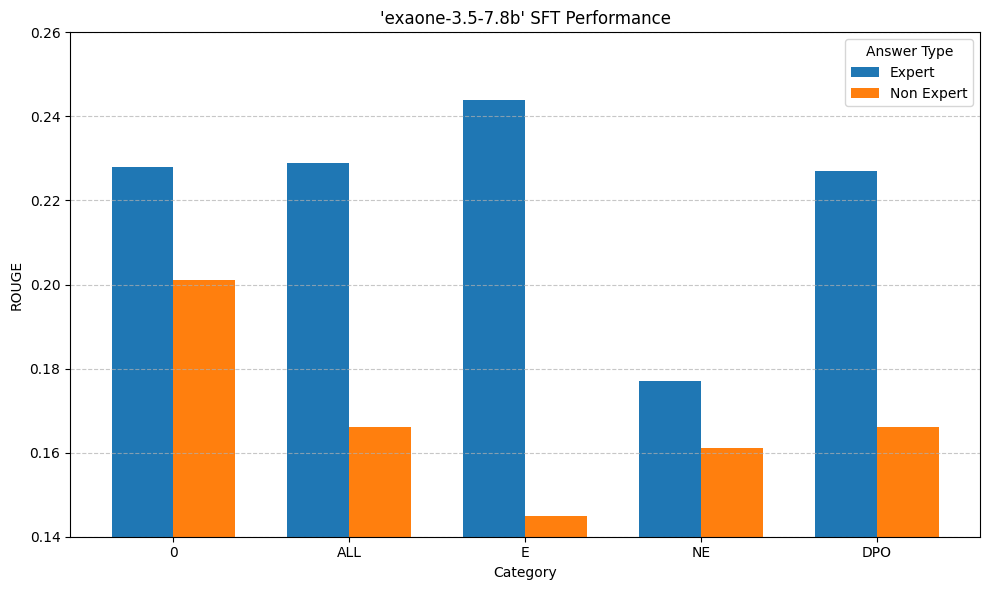

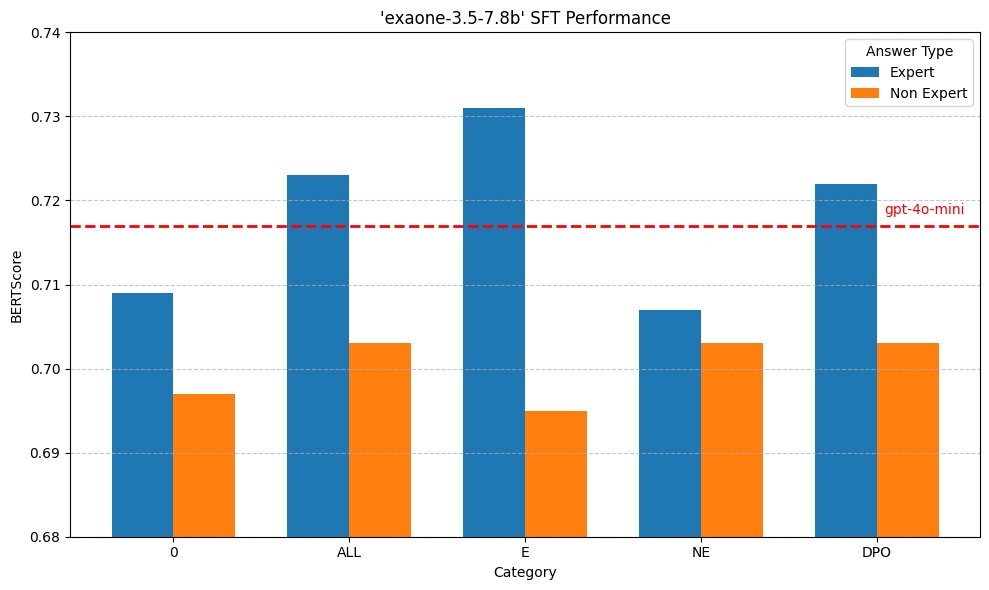

In [ ]:
model_name = "exaone-3.5-7.8b"
categories_to_extract = ["0", "ALL", "E", "NE", "DPO"]
metrics = ["ROUGE", "BERTScore"]

# 데이터 추출 및 DataFrame 생성
plot_data = []
for user_type, user_data in data_structured[model_name].items():
    for category in categories_to_extract:
        for metric in metrics:
            plot_data.append({
                "User Type": user_type,
                "Category": category,
                "Metric": metric,
                "Score": user_data[category][metric]
            })

df = pd.DataFrame(plot_data)

y_lim_ranges = {
    "ROUGE": (0.14, 0.26),  # ROUGE 점수에 적합한 범위
    "BERTScore": (0.68, 0.74) # BERTScore 점수에 적합한 범위
}

# 각 평가지표별로 그래프 생성
for metric_to_plot in metrics:
    df_metric = df[df["Metric"] == metric_to_plot]

    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x_positions = range(len(categories_to_extract))

    expert_scores = [df_metric[(df_metric["User Type"] == "Expert") & (df_metric["Category"] == cat)]["Score"].values[0]
                     if not df_metric[(df_metric["User Type"] == "Expert") & (df_metric["Category"] == cat)].empty
                     else 0 # 데이터가 없을 경우 0으로 처리하거나, 다른 방식으로 처리 가능
                     for cat in categories_to_extract]

    non_expert_scores = [df_metric[(df_metric["User Type"] == "Non Expert") & (df_metric["Category"] == cat)]["Score"].values[0]
                         if not df_metric[(df_metric["User Type"] == "Non Expert") & (df_metric["Category"] == cat)].empty
                         else 0 # 데이터가 없을 경우 0으로 처리하거나, 다른 방식으로 처리 가능
                         for cat in categories_to_extract]

    plt.bar([p - bar_width/2 for p in x_positions], expert_scores, bar_width, label="Expert")
    plt.bar([p + bar_width/2 for p in x_positions], non_expert_scores, bar_width, label="Non Expert")

    plt.xlabel("Category")
    plt.ylabel(metric_to_plot)
    # plt.title(f"'{model_name}'  Performance")
    plt.xticks(x_positions, categories_to_extract)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title="Answer Type")
    
    if metric_to_plot in y_lim_ranges:
        plt.ylim(y_lim_ranges[metric_to_plot])
        
    if metric_to_plot == "BERTScore":
        gpt4o_mini_bertscore = 0.717
        plt.axhline(y=gpt4o_mini_bertscore, color='red', linestyle='--', linewidth=2, label='gpt-4o-mini')
        plt.text(
            x=len(categories_to_extract)-0.5,  # x축 오른쪽 끝에 가깝게
            y=gpt4o_mini_bertscore + 0.001,    # 선 바로 위에
            s='gpt-4o-mini',
            color='red',
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
        )
    plt.tight_layout()
    plt.show()

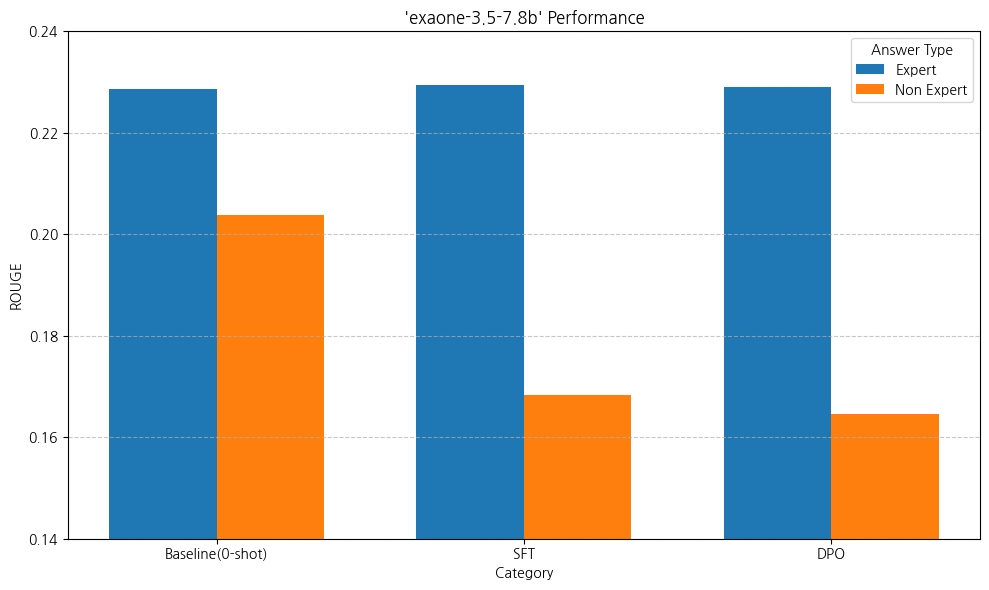

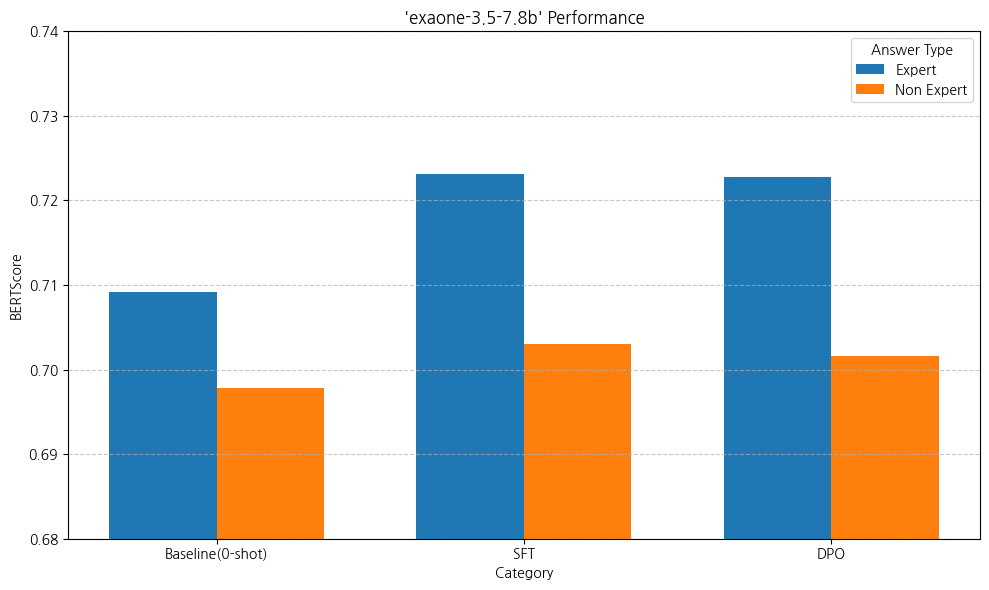

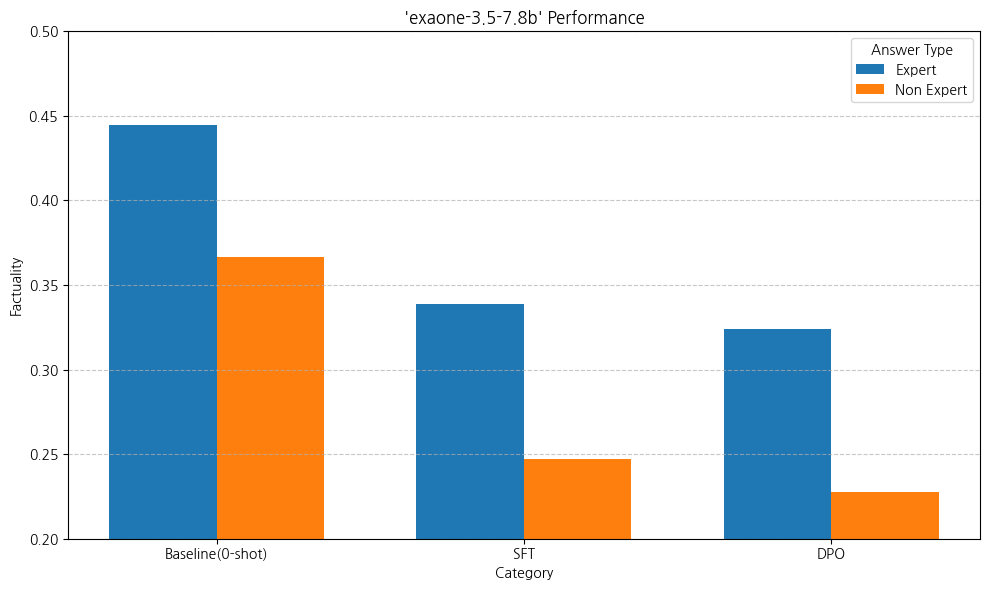

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sample_counts = {
    'Expert': {
        'Dog': 2083,
        'Cat': 413,
    },
    'Non Expert': {
        'Dog': 4541,
        'Cat': 2963,
    }
}

model_name = "exaone-3.5-7.8b"
categories_to_extract = [0, "ALL", "DPO"] 
metrics = ["ROUGE", "BERTScore", "Factuality"]
input_format = 'preprocessed'

plot_data = []
for answer_type in sample_counts.keys():
    for metric in metrics:
        for category in categories_to_extract:
            scores_to_average = []
            weights = []
            for animal_type, count in sample_counts[answer_type].items():
                score = data_structured[answer_type][model_name][animal_type][input_format][category][metric]
                scores_to_average.append(score)
                weights.append(count)

            if scores_to_average:
                weighted_avg_score = np.average(scores_to_average, weights=weights)
                
                plot_data.append({
                    "Answer Type": answer_type,
                    "Category": category,
                    "Metric": metric,
                    "Score": weighted_avg_score
                })

# --- 2. DataFrame 생성 및 시각화 ---
df = pd.DataFrame(plot_data)

y_lim_ranges = {
    "ROUGE": (0.14, 0.24),
    "BERTScore": (0.68, 0.74),
    "Factuality": (0.2, 0.5)
}

# 각 평가지표별로 그래프 생성
for metric_to_plot in metrics:
    df_metric = df[df["Metric"] == metric_to_plot]
    
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x_positions = np.arange(len(categories_to_extract))

    # 데이터프레임에서 Expert와 Non Expert 점수 추출
    expert_scores = df_metric[df_metric["Answer Type"] == "Expert"].set_index("Category").reindex(categories_to_extract)["Score"].fillna(0)
    non_expert_scores = df_metric[df_metric["Answer Type"] == "Non Expert"].set_index("Category").reindex(categories_to_extract)["Score"].fillna(0)

    plt.bar(x_positions - bar_width/2, expert_scores, bar_width, label="Expert")
    plt.bar(x_positions + bar_width/2, non_expert_scores, bar_width, label="Non Expert")

    plt.xlabel("Category")
    plt.ylabel(metric_to_plot)
    plt.title(f"'{model_name}' Performance")
    
    x_tick_labels = ['Baseline(0-shot)', 'SFT', 'DPO']
    plt.xticks(x_positions, x_tick_labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title="Answer Type")
    
    if metric_to_plot in y_lim_ranges:
        plt.ylim(y_lim_ranges[metric_to_plot])
        
    plt.tight_layout()
    plt.show()

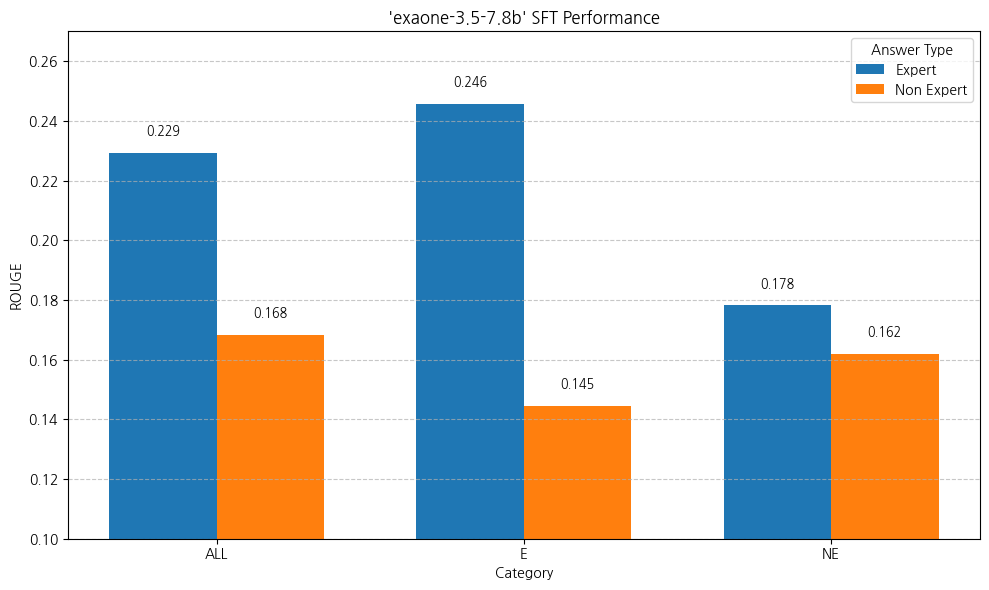

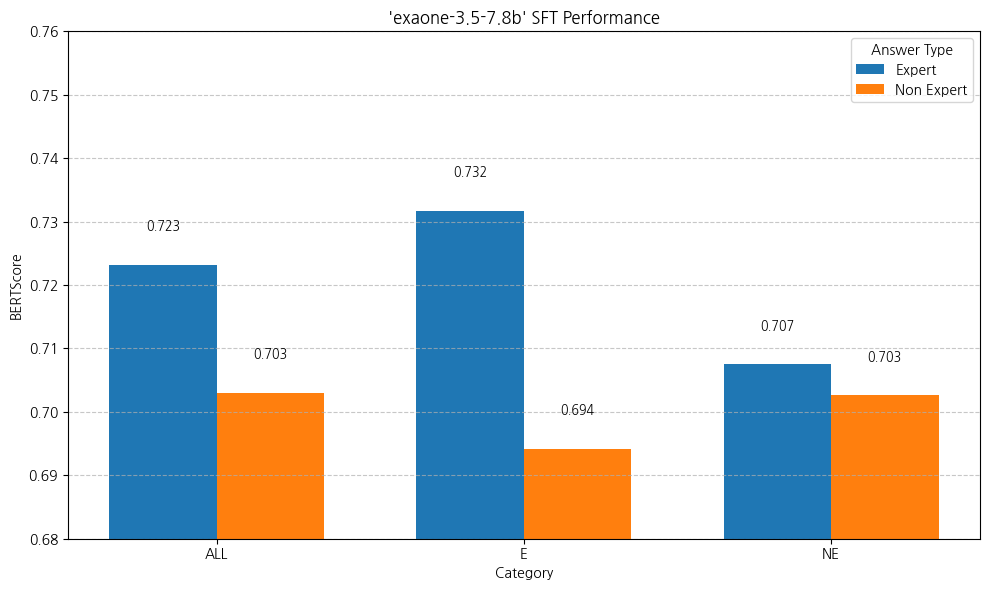

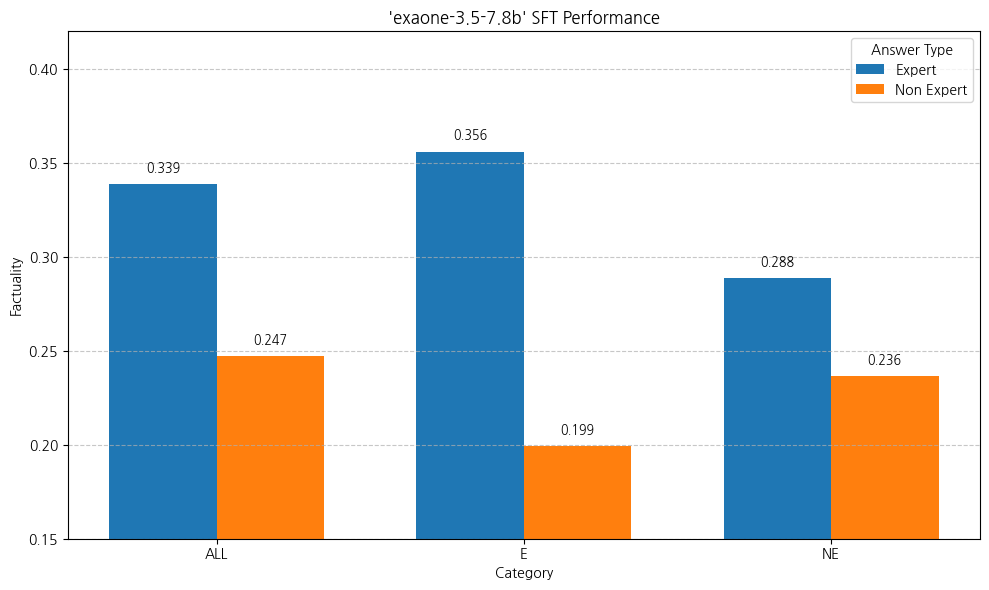

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sample_counts = {
    'Expert': {
        'Dog': 2083,
        'Cat': 413,
    },
    'Non Expert': {
        'Dog': 4541,
        'Cat': 2963,
    }
}

model_name = "exaone-3.5-7.8b"
categories_to_extract = ["ALL", "E", "NE"] 
metrics = ["ROUGE", "BERTScore", "Factuality"]
input_format = 'preprocessed'

plot_data = []
for answer_type in sample_counts.keys():
    for metric in metrics:
        for category in categories_to_extract:
            scores_to_average = []
            weights = []
            for animal_type, count in sample_counts[answer_type].items():
                score = data_structured[answer_type][model_name][animal_type][input_format][category][metric]
                scores_to_average.append(score)
                weights.append(count)

            if scores_to_average:
                weighted_avg_score = np.average(scores_to_average, weights=weights)
                
                plot_data.append({
                    "Answer Type": answer_type,
                    "Category": category,
                    "Metric": metric,
                    "Score": weighted_avg_score
                })

# --- 2. DataFrame 생성 및 시각화 ---
df = pd.DataFrame(plot_data)

y_lim_ranges = {
    "ROUGE": (0.10, 0.25),
    "BERTScore": (0.68, 0.74),
    "Factuality": (0.15, 0.40)
}

# 각 평가지표별로 그래프 생성
for metric_to_plot in metrics:
    df_metric = df[df["Metric"] == metric_to_plot]
    
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x_positions = np.arange(len(categories_to_extract))

    # 데이터프레임에서 Expert와 Non Expert 점수 추출
    expert_scores = df_metric[df_metric["Answer Type"] == "Expert"].set_index("Category").reindex(categories_to_extract)["Score"].fillna(0)
    non_expert_scores = df_metric[df_metric["Answer Type"] == "Non Expert"].set_index("Category").reindex(categories_to_extract)["Score"].fillna(0)

    # 막대그래프 그리기
    bars1 = plt.bar(x_positions - bar_width/2, expert_scores, bar_width, label="Expert")
    bars2 = plt.bar(x_positions + bar_width/2, non_expert_scores, bar_width, label="Non Expert")

    # Expert 막대 위에 값 표시
    for i, (bar, score) in enumerate(zip(bars1, expert_scores)):
        if score > 0:  # 값이 0이 아닐 때만 표시
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9)

    # Non Expert 막대 위에 값 표시
    for i, (bar, score) in enumerate(zip(bars2, non_expert_scores)):
        if score > 0:  # 값이 0이 아닐 때만 표시
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9)

    plt.xlabel("Category")
    plt.ylabel(metric_to_plot)
    plt.title(f"'{model_name}' SFT Performance")
    
    plt.xticks(x_positions, categories_to_extract)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title="Answer Type")
    
    if metric_to_plot in y_lim_ranges:
        # y축 범위를 조정하여 텍스트가 잘리지 않도록 함
        y_min, y_max = y_lim_ranges[metric_to_plot]
        plt.ylim(y_min, y_max + 0.02)  # 위쪽 여백을 조금 더 추가
        
    plt.tight_layout()
    plt.show()

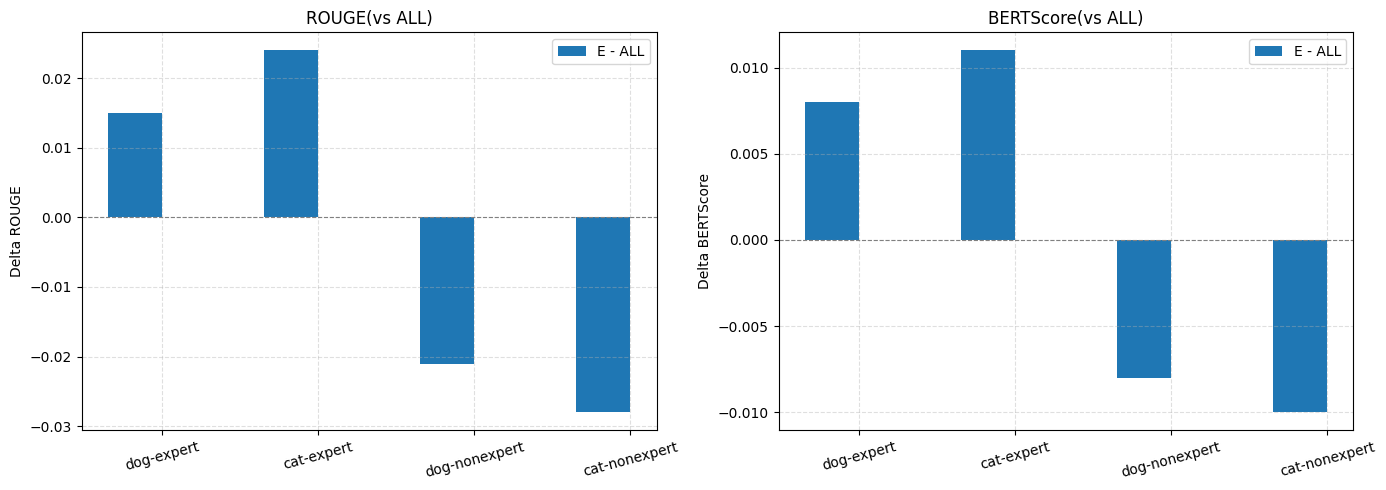

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



categories = ['dog-expert', 'cat-expert', 'dog-nonexpert', 'cat-nonexpert']

# 결과 저장용
metrics = {'ROUGE': [], 'BERTScore': []}

# baseline (ALL) 기준 값들
for category in categories:
    animal, ans_type = category.split('-')
    base = data_sft_raw['ALL']['Expert' if ans_type == 'expert' else 'Non Expert'][animal.capitalize()]['preprocessed']
    e = data_sft_raw['E']['Expert' if ans_type == 'expert' else 'Non Expert'][animal.capitalize()]['preprocessed']
    ne = data_sft_raw['NE']['Expert' if ans_type == 'expert' else 'Non Expert'][animal.capitalize()]['preprocessed']

    # 상대적 변화량 (E - ALL), (NE - ALL)
    metrics['ROUGE'].append([e['ROUGE'] - base['ROUGE'], ne['ROUGE'] - base['ROUGE']])
    metrics['BERTScore'].append([e['BERTScore'] - base['BERTScore'], ne['BERTScore'] - base['BERTScore']])

# 시각화
x = np.arange(len(categories))
width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i, metric in enumerate(['ROUGE', 'BERTScore']):
    e_vals = [x[0] for x in metrics[metric]]
    ne_vals = [x[1] for x in metrics[metric]]

    axs[i].bar(x - width/2, e_vals, width, label='E - ALL')
    # axs[i].bar(x + width/2, ne_vals, width, label='NE - ALL')

    axs[i].set_ylabel(f'Delta {metric}')
    axs[i].set_title(f'{metric}(vs ALL)')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(categories, rotation=15)
    axs[i].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axs[i].legend()
    axs[i].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

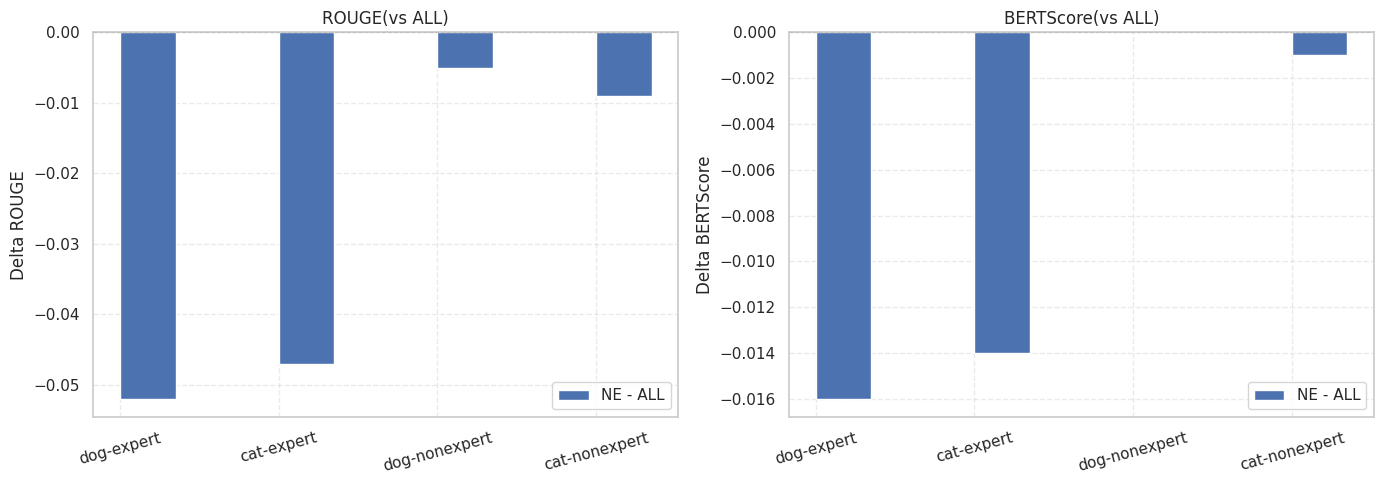

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



categories = ['dog-expert', 'cat-expert', 'dog-nonexpert', 'cat-nonexpert']

# 결과 저장용
metrics = {'ROUGE': [], 'BERTScore': []}

# baseline (ALL) 기준 값들
for category in categories:
    animal, ans_type = category.split('-')
    base = data_sft_raw['ALL']['Expert' if ans_type == 'expert' else 'Non Expert'][animal.capitalize()]['preprocessed']
    e = data_sft_raw['E']['Expert' if ans_type == 'expert' else 'Non Expert'][animal.capitalize()]['preprocessed']
    ne = data_sft_raw['NE']['Expert' if ans_type == 'expert' else 'Non Expert'][animal.capitalize()]['preprocessed']

    # 상대적 변화량 (E - ALL), (NE - ALL)
    metrics['ROUGE'].append([e['ROUGE'] - base['ROUGE'], ne['ROUGE'] - base['ROUGE']])
    metrics['BERTScore'].append([e['BERTScore'] - base['BERTScore'], ne['BERTScore'] - base['BERTScore']])

# 시각화
x = np.arange(len(categories))
width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i, metric in enumerate(['ROUGE', 'BERTScore']):
    e_vals = [x[0] for x in metrics[metric]]
    ne_vals = [x[1] for x in metrics[metric]]

    # axs[i].bar(x - width/2, e_vals, width, label='E - ALL')
    axs[i].bar(x + width/2, ne_vals, width, label='NE - ALL')

    axs[i].set_ylabel(f'Delta {metric}')
    axs[i].set_title(f'{metric}(vs ALL)')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(categories, rotation=15)
    axs[i].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axs[i].legend()
    axs[i].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_raw = {
    'Expert': {
        'gpt-4o-mini': {
            'Dog': {
                'preprocessed': {'ROUGE': 0.243, 'BERTScore': 0.717},
                'raw': {'ROUGE': 0.243, 'BERTScore': 0.715}
            },
            'Cat': {
                'preprocessed': {'ROUGE': 0.249, 'BERTScore': 0.719},
                'raw': {'ROUGE': 0.250, 'BERTScore': 0.719}
            }
        },
        'exaone-3.5-7.8b': {
            'Dog': {'preprocessed': {'ROUGE': 0.228, 'BERTScore': 0.709},
                    'raw': {'ROUGE': 0.224, 'BERTScore': 0.703}},
            'Cat': {'preprocessed': {'ROUGE': 0.232, 'BERTScore': 0.710},
                    'raw': {'ROUGE': 0.231, 'BERTScore': 0.705}}
        }
    },
    'Non Expert': {
        'gpt-4o-mini': {
            'Dog': {'preprocessed': {'ROUGE': 0.226, 'BERTScore': 0.708},
                    'raw': {'ROUGE': 0.225, 'BERTScore': 0.708}},
            'Cat': {'preprocessed': {'ROUGE': 0.231, 'BERTScore': 0.710},
                    'raw': {'ROUGE': 0.232, 'BERTScore': 0.711}}
        },
        
        'exaone-3.5-7.8b': {
            'Dog': {'preprocessed': {'ROUGE': 0.201, 'BERTScore': 0.697},
                    'raw': {'ROUGE': 0.199, 'BERTScore': 0.693}},
            'Cat': {'preprocessed': {'ROUGE': 0.208, 'BERTScore': 0.699},
                    'raw': {'ROUGE': 0.204, 'BERTScore': 0.693}}
        }
    }
}

In [3]:
MODEL_NAME = 'gpt-4o-mini'
# MODEL_NAME = 'exaone-3.5-7.8b'
# MODEL_NAME = 'qwen-2.5-7b'

/tmp/ipykernel_2040133/379913673.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
/tmp/ipykernel_2040133/379913673.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)


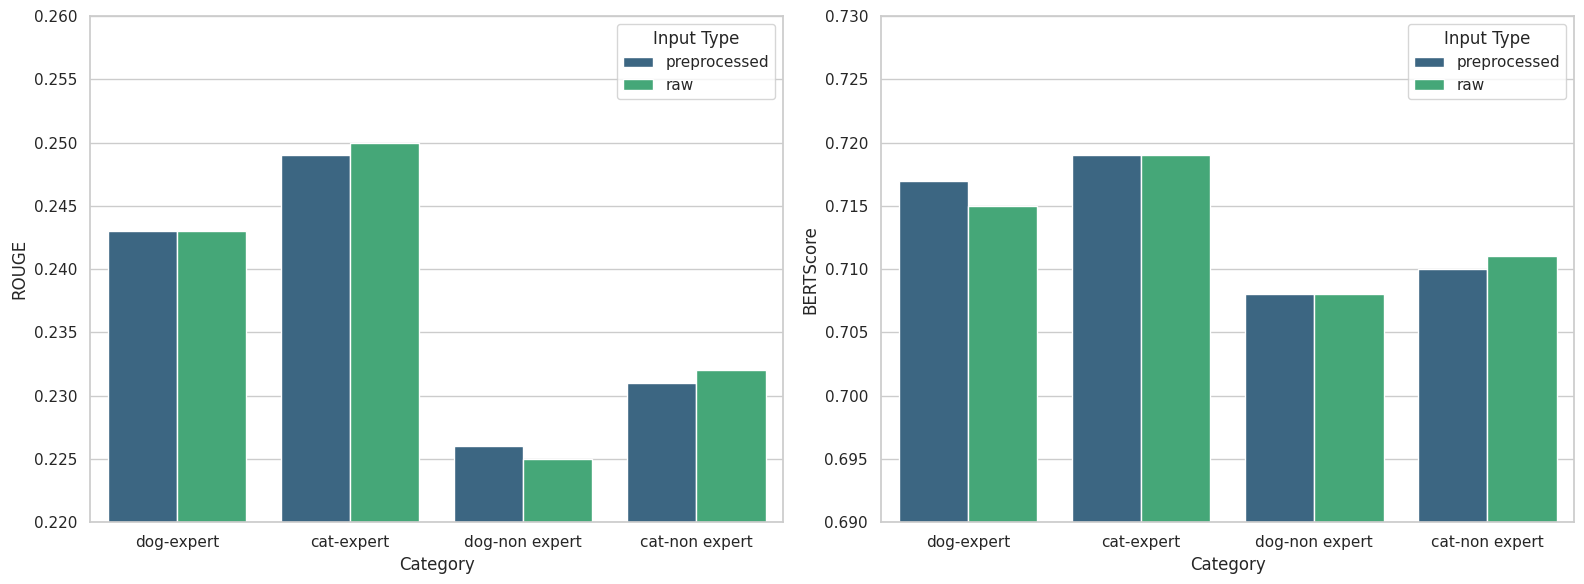

In [8]:
data_list = []
for answer_type, models_data in data_raw.items():
    for model, animal_types in models_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, scores in input_types_data.items():
                row = {
                    'Answer Type': answer_type,
                    'Model': model,
                    'Animal': animal,
                    'Input Type': input_type,
                    'ROUGE': scores['ROUGE'],
                    'BERTScore': scores['BERTScore']
                }
                data_list.append(row)
                
df = pd.DataFrame(data_list)

df['Combined'] = df['Animal'].str.lower() + '-' + df['Answer Type'].str.lower()

df_cell1 = df[df['Model'] == MODEL_NAME].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# fig.suptitle(f'Performance by Input Format (Model: {MODEL_NAME})', fontsize=18, y=1.05)
# fig.suptitle(f'Performance by Input Format', fontsize=18, y=1.05)

# ROUGE
sns.barplot(
    ax=axes[0],
    data=df_cell1,
    x='Combined',
    y='ROUGE',
    hue='Input Type',
    palette='viridis'
)
# axes[0].set_title('ROUGE', fontsize=14)
axes[0].set_xlabel('Category')
axes[0].set_ylabel('ROUGE')
axes[0].set_ylim(0.22, 0.26)
axes[0].set_yticks(np.arange(0.22, 0.261, 0.005)) 
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# BERTScore
sns.barplot(
    ax=axes[1],
    data=df_cell1,
    x='Combined',
    y='BERTScore',
    hue='Input Type',
    palette='viridis'
)
# axes[1].set_title('BERTScore', fontsize=14)
axes[1].set_xlabel('Category')
axes[1].set_ylabel('BERTScore')
axes[1].set_ylim(0.69, 0.73)
axes[1].set_yticks(np.arange(0.69, 0.731, 0.005))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()
plt.close()

/tmp/ipykernel_1918069/1754115305.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
/tmp/ipykernel_1918069/1754115305.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)


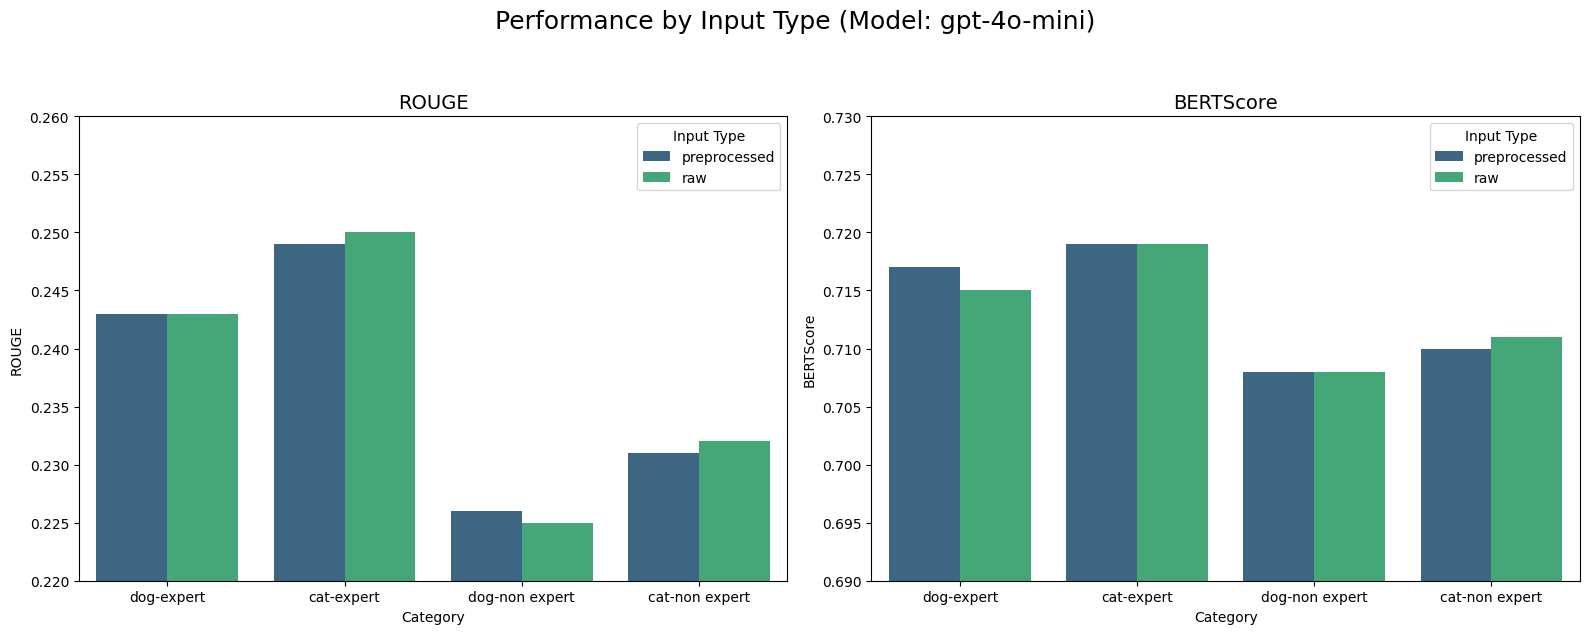

In [126]:
data_list = []
for answer_type, models_data in data_raw.items():
    for model, animal_types in models_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, scores in input_types_data.items():
                row = {
                    'Answer Type': answer_type,
                    'Model': model,
                    'Animal': animal,
                    'Input Type': input_type,
                    'ROUGE': scores['ROUGE'],
                    'BERTScore': scores['BERTScore']
                }
                data_list.append(row)
                
df = pd.DataFrame(data_list)

df['Combined'] = df['Animal'].str.lower() + '-' + df['Answer Type'].str.lower()

df_cell1 = df[df['Model'] == MODEL_NAME].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Performance by Input Type (Model: {MODEL_NAME})', fontsize=18, y=1.05)

# ROUGE
sns.barplot(
    ax=axes[0],
    data=df_cell1,
    x='Combined',
    y='ROUGE',
    hue='Input Type',
    palette='viridis'
)
axes[0].set_title('ROUGE', fontsize=14)
axes[0].set_xlabel('Category')
axes[0].set_ylabel('ROUGE')
axes[0].set_ylim(0.22, 0.26)
axes[0].set_yticks(np.arange(0.22, 0.261, 0.005)) 
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# BERTScore
sns.barplot(
    ax=axes[1],
    data=df_cell1,
    x='Combined',
    y='BERTScore',
    hue='Input Type',
    palette='viridis'
)
axes[1].set_title('BERTScore', fontsize=14)
axes[1].set_xlabel('Category')
axes[1].set_ylabel('BERTScore')
axes[1].set_ylim(0.69, 0.73)
axes[1].set_yticks(np.arange(0.69, 0.731, 0.005))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()
plt.close()

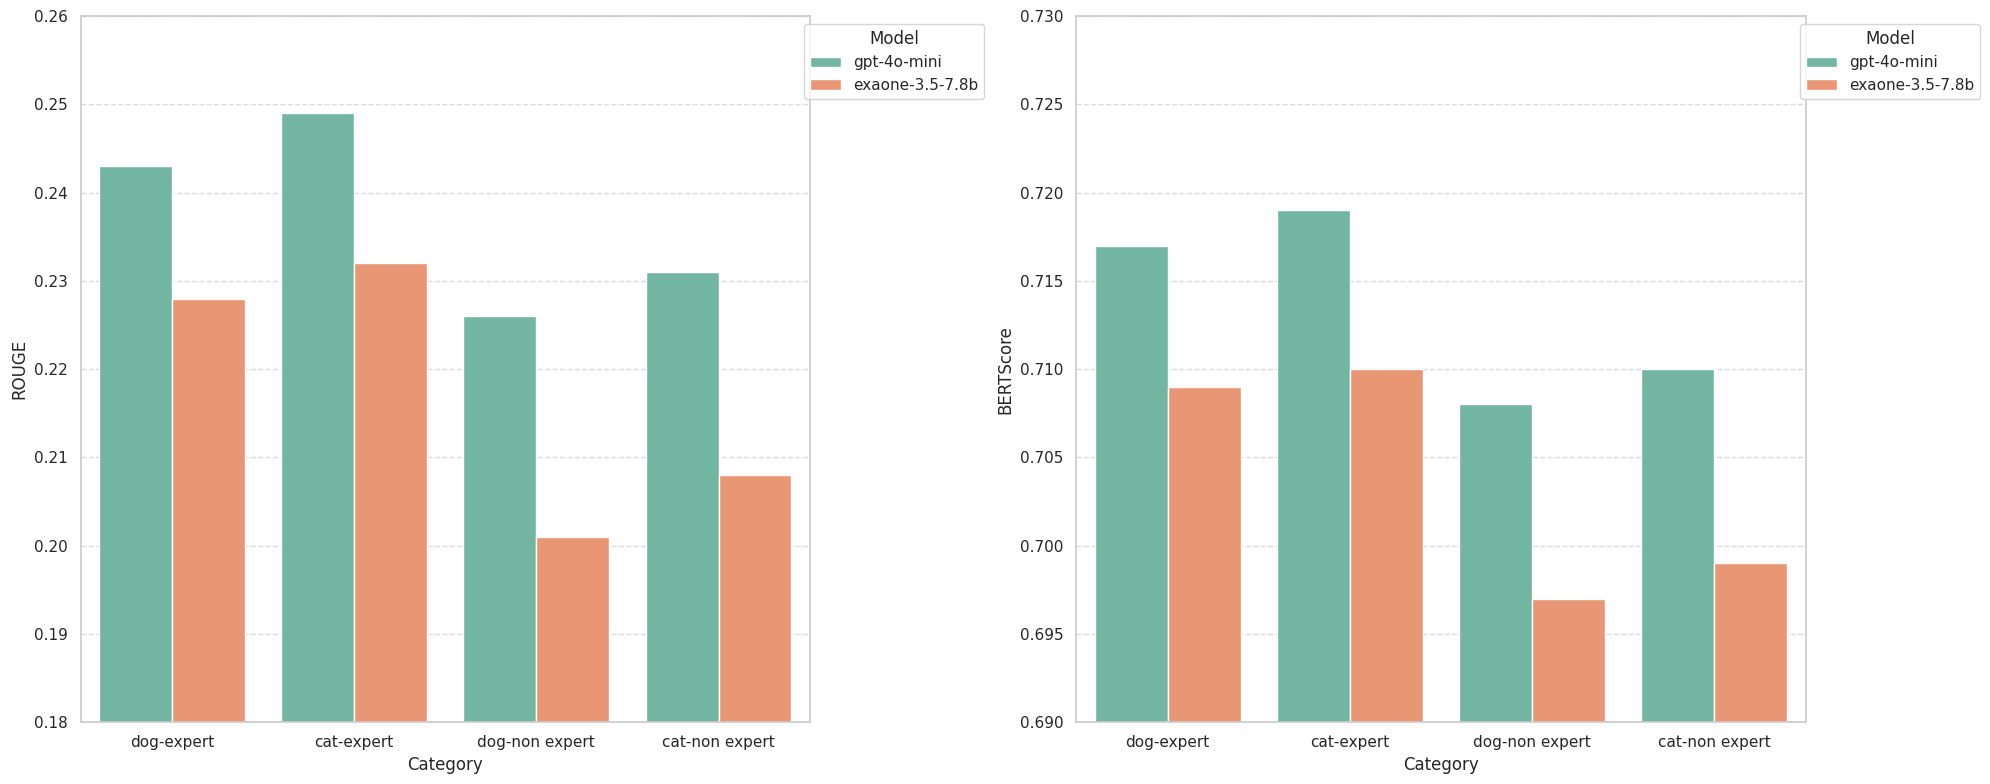

In [10]:
data_list = []
for expertise, models in data_raw.items():
    for model_name, categories in models.items():
        for category, formats in categories.items():
            for input_format, scores in formats.items():
                for score_metric, score_value in scores.items():
                    data_list.append({
                        'Expertise': expertise,
                        'Model': model_name,
                        'Category': category,
                        'Input_Format': input_format,
                        'Score_Metric': score_metric,
                        'Score_Value': score_value
                    })

df = pd.DataFrame(data_list)

# Filter for the 'preprocessed' input format as requested
df_filtered = df[df['Input_Format'] == 'preprocessed'].copy()

# Create a combined category column for the x-axis
df_filtered['Combined_Category'] = df_filtered['Category'].str.lower() + '-' +df_filtered['Expertise'].str.lower()

# Get unique score metrics
score_metrics = df_filtered['Score_Metric'].unique()

# Set up the plot style
sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
# fig.suptitle('Model Performance by Category (Preprocessed)', fontsize=18, y=1.02)

# Define ylim settings for each metric
ylim_settings = {
    'ROUGE': (0.18, 0.26),
    'BERTScore': (0.69, 0.73)
}

# Create plots for each metric
for i, metric in enumerate(score_metrics):
    # Filter data for the current metric
    df_metric = df_filtered[df_filtered['Score_Metric'] == metric]
    
    # Create the plot on the corresponding subplot
    sns.barplot(
        x='Combined_Category',
        y='Score_Value',
        hue='Model',
        data=df_metric,
        ax=axes[i],
        palette='Set2'
    )

    # Set titles and labels
    # axes[i].set_title(f'{metric}', fontsize=16)
    axes[i].set_xlabel('Category', fontsize=12)
    axes[i].set_ylabel(f'{metric}', fontsize=12)

    # Set different ylim for each metric
    axes[i].set_ylim(ylim_settings[metric])
    
    # Adjust legend and ticks
    axes[i].legend(title='Model', loc='upper right', bbox_to_anchor=(1.25, 1))
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
plt.close(fig)

/tmp/ipykernel_2040133/2128675626.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Combined_Category'] = df_model['Category'].str.lower() + '-' +df_model['Expertise'].str.lower()


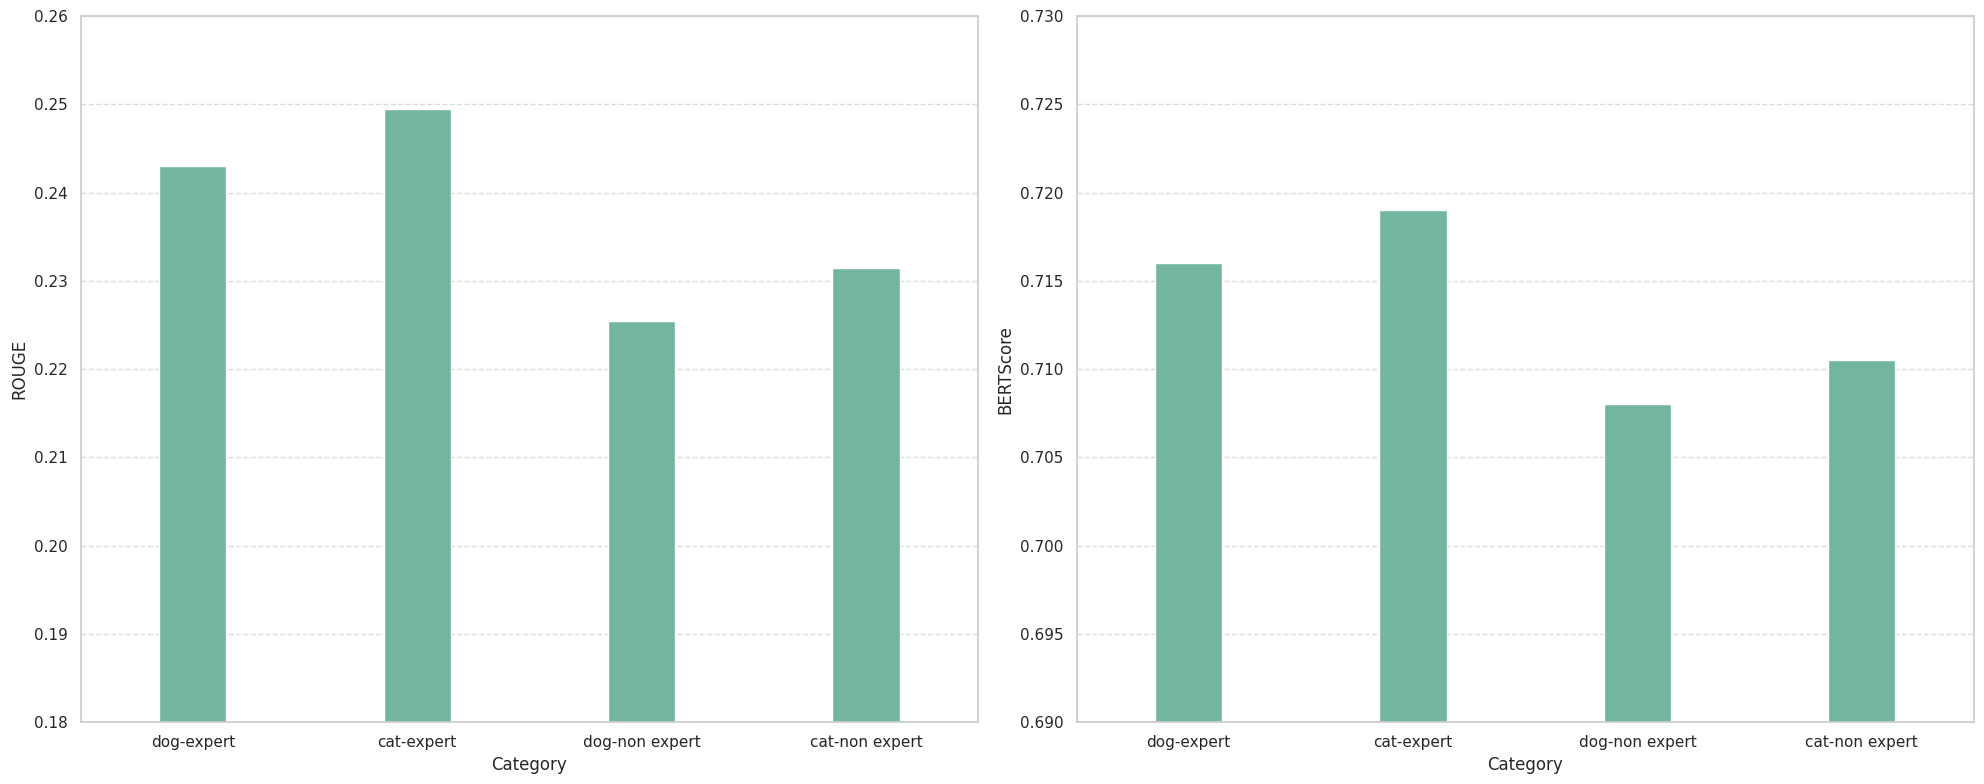

In [26]:
data_list = []
for expertise, models in data_raw.items():
    for model_name, categories in models.items():
        for category, formats in categories.items():
            for input_format, scores in formats.items():
                for score_metric, score_value in scores.items():
                    data_list.append({
                        'Expertise': expertise,
                        'Model': model_name,
                        'Category': category,
                        'Input_Format': input_format,
                        'Score_Metric': score_metric,
                        'Score_Value': score_value
                    })

df = pd.DataFrame(data_list)

target_model = "gpt-4o-mini"
df_model = df[df['Model'] == target_model]
df_model['Combined_Category'] = df_model['Category'].str.lower() + '-' +df_model['Expertise'].str.lower()


# Get unique score metrics
score_metrics = df_model['Score_Metric'].unique()

# Set up the plot style
sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(1, len(score_metrics), figsize=(20, 8))

# Ensure axes is iterable
if len(score_metrics) == 1:
    axes = [axes]

# Define ylim settings for each metric (필요시 수정)
ylim_settings = {
    'ROUGE': (0.18, 0.26),
    'BERTScore': (0.69, 0.73)
}

# Create plots for each metric
for i, metric in enumerate(score_metrics):
    # Filter data for the current metric
    df_metric = df_model[df_model['Score_Metric'] == metric]

    sns.barplot(
        x='Combined_Category',
        y='Score_Value',
        data=df_metric,
        ax=axes[i],
        color='#66c2a5',
        width=0.3,
        errorbar=None
    )

    axes[i].set_xlabel('Category', fontsize=12)
    axes[i].set_ylabel(f'{metric}', fontsize=12)
    axes[i].set_ylim(ylim_settings.get(metric, (df_metric['Score_Value'].min(), df_metric['Score_Value'].max())))
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
plt.close(fig)

In [43]:
INPUT_TYPE = "preprocessed"
# INPUT_TYPE = 'raw'

/tmp/ipykernel_1918069/380963527.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
/tmp/ipykernel_1918069/380963527.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)


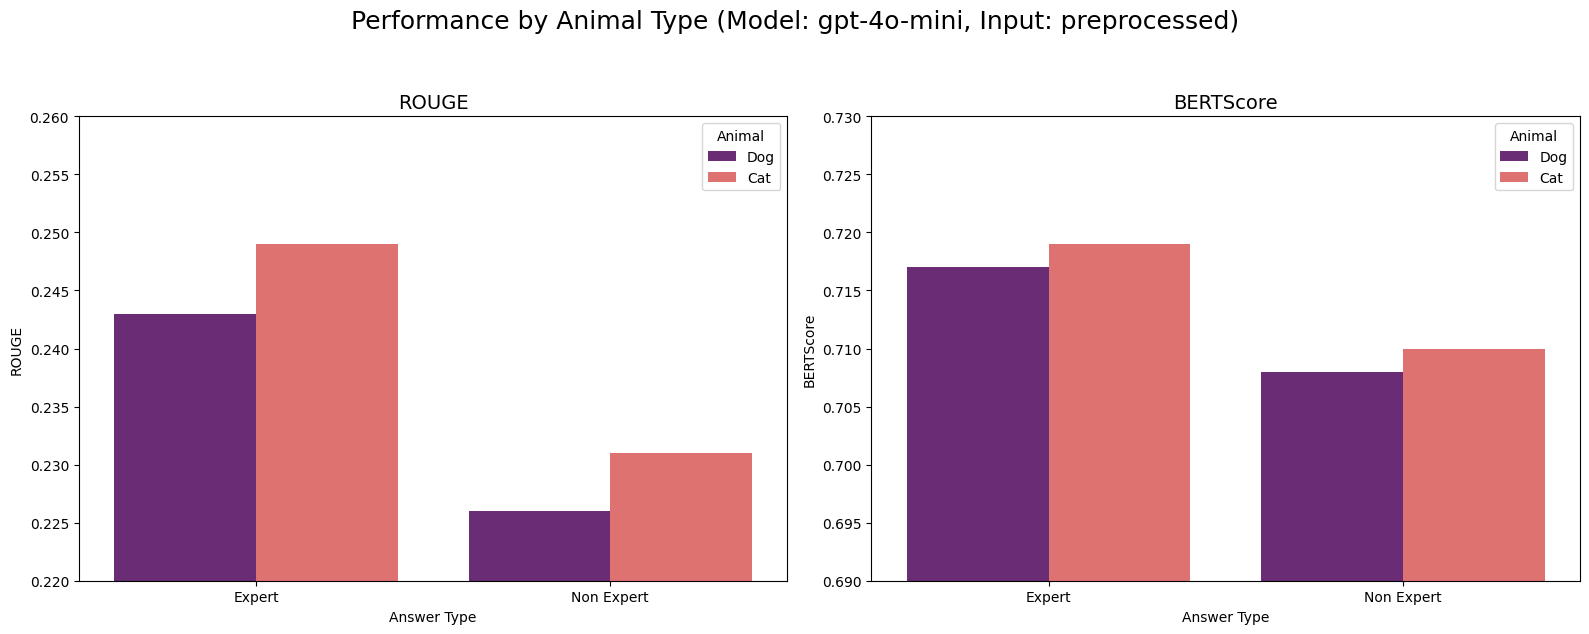

In [120]:
data_list = []
for answer_type, models_data in data_raw.items():
    for model, animal_types in models_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, scores in input_types_data.items():
                row = {
                    'Answer Type': answer_type,
                    'Model': model,
                    'Animal': animal,
                    'Input Type': input_type,
                    'ROUGE': scores['ROUGE'],
                    'BERTScore': scores['BERTScore']
                }
                data_list.append(row)
df = pd.DataFrame(data_list)

df_cell2 = df[(df['Model'] == MODEL_NAME) & (df['Input Type'] == INPUT_TYPE)].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Performance by Animal Type (Model: {MODEL_NAME}, Input: {INPUT_TYPE})', fontsize=18, y=1.05)

sns.barplot(
    ax=axes[0],
    data=df_cell2,
    x='Answer Type',
    y='ROUGE',
    hue='Animal',
    palette='magma'
)
axes[0].set_title('ROUGE', fontsize=14)
axes[0].set_xlabel('Answer Type')
axes[0].set_ylabel('ROUGE')
axes[0].set_ylim(0.22, 0.26)
axes[0].set_yticks(np.arange(0.22, 0.261, 0.005))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# BERTScore
sns.barplot(
    ax=axes[1],
    data=df_cell2,
    x='Answer Type',
    y='BERTScore',
    hue='Animal',
    palette='magma'
)
axes[1].set_title('BERTScore', fontsize=14)
axes[1].set_xlabel('Answer Type')
axes[1].set_ylabel('BERTScore')
axes[1].set_ylim(0.69, 0.73)
axes[1].set_yticks(np.arange(0.69, 0.731, 0.005))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()
plt.close()

/tmp/ipykernel_1918069/3531653155.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
/tmp/ipykernel_1918069/3531653155.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)


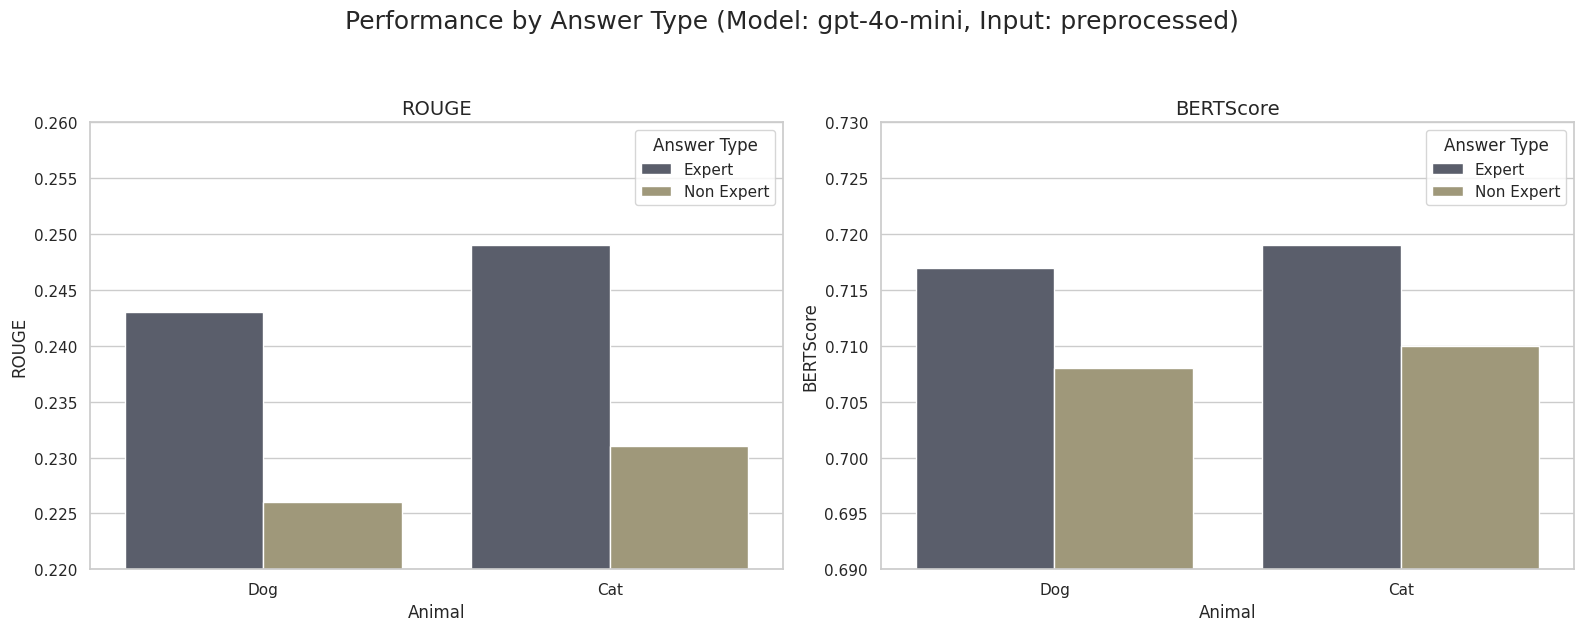

In [149]:
data_list = []
for answer_type, models_data in data_raw.items():
    for model, animal_types in models_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, scores in input_types_data.items():
                row = {
                    'Answer Type': answer_type,
                    'Model': model,
                    'Animal': animal,
                    'Input Type': input_type,
                    'ROUGE': scores['ROUGE'],
                    'BERTScore': scores['BERTScore']
                }
                data_list.append(row)
df = pd.DataFrame(data_list)

df_cell3 = df[(df['Model'] == MODEL_NAME) & (df['Input Type'] == INPUT_TYPE)].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Performance by Answer Type (Model: {MODEL_NAME}, Input: {INPUT_TYPE})', fontsize=18, y=1.05)

sns.barplot(
    ax=axes[0],
    data=df_cell3,
    x='Animal',
    y='ROUGE',
    hue='Answer Type',
    palette='cividis'
)
axes[0].set_title('ROUGE', fontsize=14)
axes[0].set_xlabel('Animal')
axes[0].set_ylabel('ROUGE')
axes[0].set_ylim(0.22, 0.26)
axes[0].set_yticks(np.arange(0.22, 0.261, 0.005))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

sns.barplot(
    ax=axes[1],
    data=df_cell3,
    x='Animal',
    y='BERTScore',
    hue='Answer Type',
    palette='cividis'
)
axes[1].set_title('BERTScore', fontsize=14)
axes[1].set_xlabel('Animal')
axes[1].set_ylabel('BERTScore')
axes[1].set_ylim(0.69, 0.73)
axes[1].set_yticks(np.arange(0.69, 0.731, 0.005))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()
plt.close()